In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, r2_score

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', family = 'Gulim')
mpl.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
train = pd.read_csv("data/train_onehotenc5.csv")
test = pd.read_csv("data/test_onehotenc5.csv")
sub = pd.read_csv("data/sample_submission.csv")

In [3]:
train['상환원금/대출금액'] = train['총상환원금']/train['대출금액']
train['상환이자/대출금액'] = train['총상환이자']/train['대출금액']
train['연체금액/대출금액'] = train['총연체금액']/train['대출금액']
train['상환/대출금액'] = (train["총상환원금"] + train["총상환이자"]) / train["대출금액"]
train['대출금액/계좌수'] = train["대출금액"] / train["총계좌수"]
train['연간소득/대출금액'] = train["연간소득"] / train["대출금액"]
train['상환/연간소득'] = (train["총상환원금"] + train["총상환이자"]) / (train["연간소득"] + 1)
train["대출기간"] = (train["대출기간"] + 1) * 36
train["대출금액/대출기간"] = train["대출금액"] / train["대출기간"]

test['상환원금/대출금액'] = test['총상환원금']/test['대출금액']
test['상환이자/대출금액'] = test['총상환이자']/test['대출금액']
test['연체금액/대출금액'] = test['총연체금액']/test['대출금액']
test['상환/대출금액'] = (test["총상환원금"] + test["총상환이자"]) / test["대출금액"]
test['대출금액/계좌수'] = test["대출금액"] / test["총계좌수"]
test['연간소득/대출금액'] = test["연간소득"] / test["대출금액"]
test['상환/연간소득'] = (test["총상환원금"] + test["총상환이자"]) / (test["연간소득"] + 1)
test["대출기간"] = (test["대출기간"] + 1) * 36
test["대출금액/대출기간"] = test["대출금액"] / test["대출기간"]


In [4]:
mapping_target = {1 : 0, 2 : 1, 3 : 2, 4 : 3, 5 : 4, 6 : 5, 7 : 6}
train["대출등급"] = train["대출등급"].replace(mapping_target)

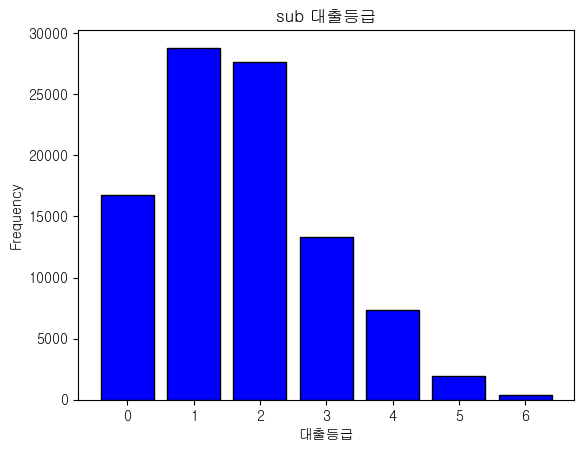

In [5]:
plt.hist(train["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("sub 대출등급")
plt.show()

In [6]:
train_36 = train.loc[train["대출기간"] == 36]
train_72 = train.loc[train["대출기간"] == 72]

# 36months

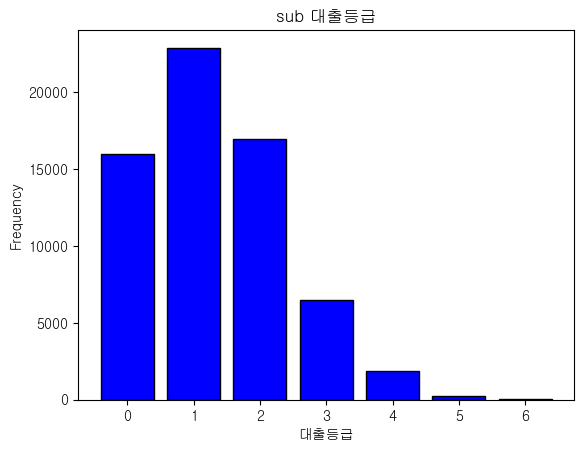

In [7]:
plt.hist(train_36["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("sub 대출등급")
plt.show()

# ABC(DEFG)

In [8]:
new_train_1 = train_36.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 6 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 7 else x)

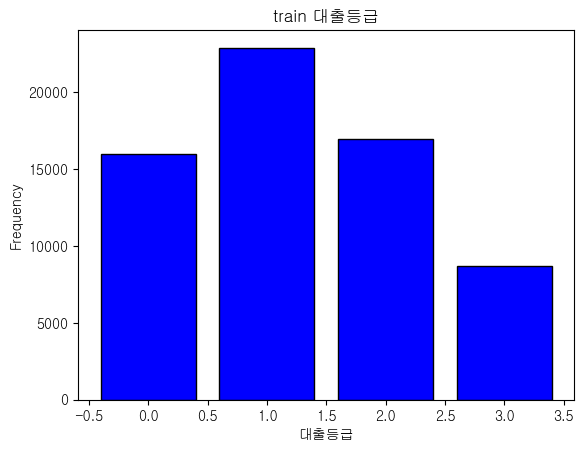

In [9]:
plt.hist(new_train_1["대출등급"], bins=range(5), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

0.186931348048766
0.9688134796809048


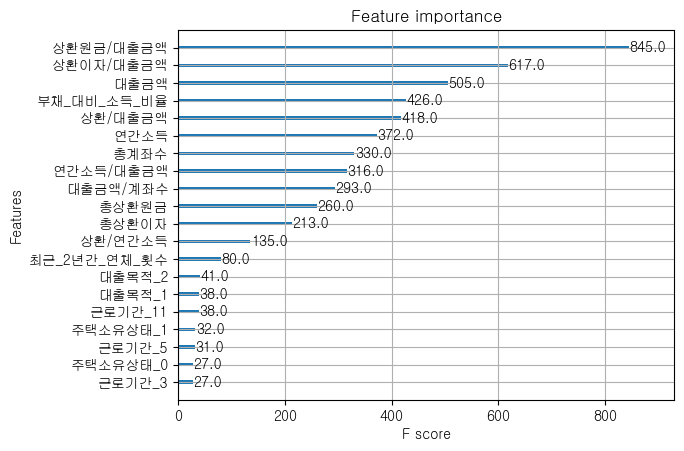

In [10]:
X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
xg = xgb.XGBRegressor()
model_1 = xg.fit(X, y)
pred = model_1.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))
xgb.plot_importance(model_1, importance_type='weight', max_num_features=20)
plt.show()

In [11]:
pred_1 = model_1.predict(test)
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 0) & (test["대출기간"] == 36), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 36), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 36), "대출등급"] = 2
sub["대출등급"].unique()

array([1, 0, 2, 'G'], dtype=object)

# D(EFG)

In [12]:
new_train_2 = train_36.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 0]
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]
new_train_2["대출등급"].unique()

array([3, 4, 5, 6], dtype=int64)

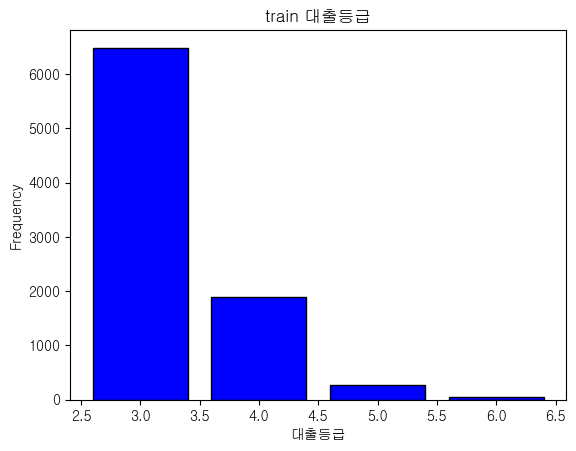

In [13]:
plt.hist(new_train_2["대출등급"], bins=range(3,8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [14]:
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==3 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==4 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==6 else x)

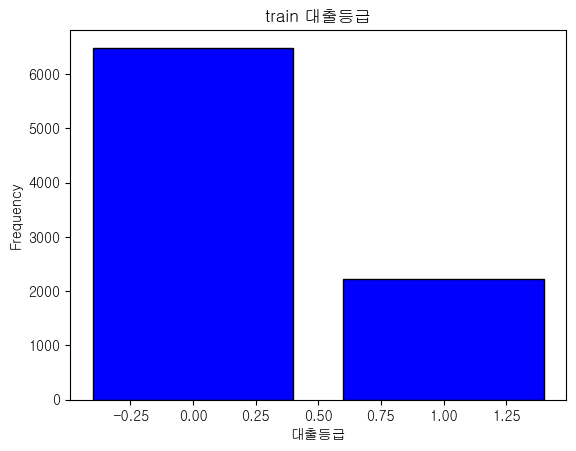

In [15]:
plt.hist(new_train_2["대출등급"], bins=range(3), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [16]:
X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)
X.shape, y.shape

((12970, 45), (12970, 1))

0.008780717642256245
0.9996915959907479


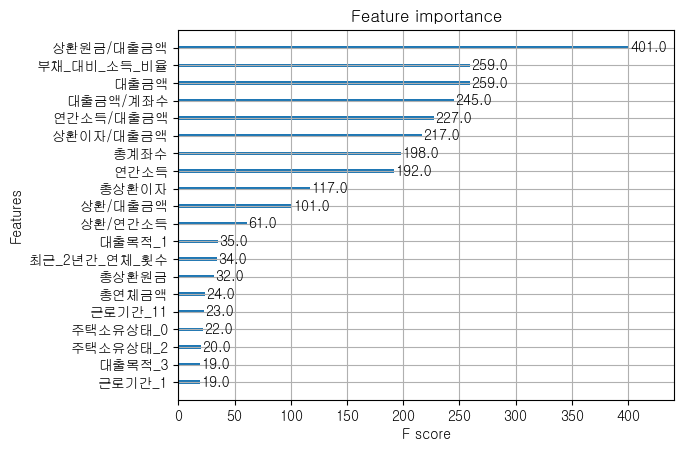

array([1, 0, 2, 'G', 3], dtype=object)

In [17]:
xg = xgb.XGBClassifier()
model_2 = xg.fit(X, y)
pred = model_2.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))
xgb.plot_importance(model_2, importance_type='weight', max_num_features=20)
plt.show()

pred_2 = model_2.predict(test)
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 36), "대출등급"] = 3
sub["대출등급"].unique()

# E(FG)

In [18]:
new_train_3 = train_36.copy()
new_train_3 = new_train_3[new_train_3["대출등급"] != 0]
new_train_3 = new_train_3[new_train_3["대출등급"] != 1]
new_train_3 = new_train_3[new_train_3["대출등급"] != 2]
new_train_3 = new_train_3[new_train_3["대출등급"] != 3]
new_train_3["대출등급"].unique()

array([4, 5, 6], dtype=int64)

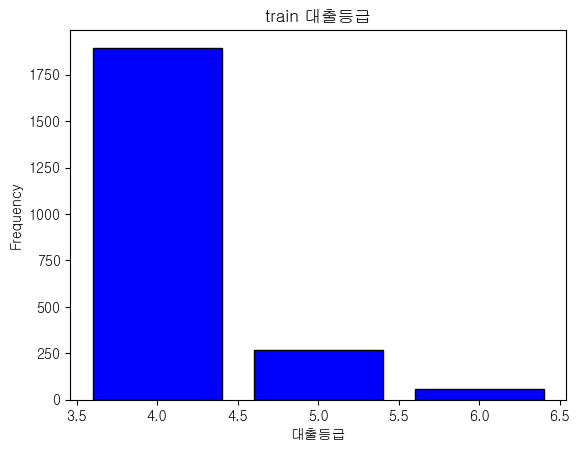

In [19]:
plt.hist(new_train_3["대출등급"], bins=range(4,8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [20]:
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:0 if x==4 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==6 else x)
new_train_3["대출등급"].unique()

array([0, 1], dtype=int64)

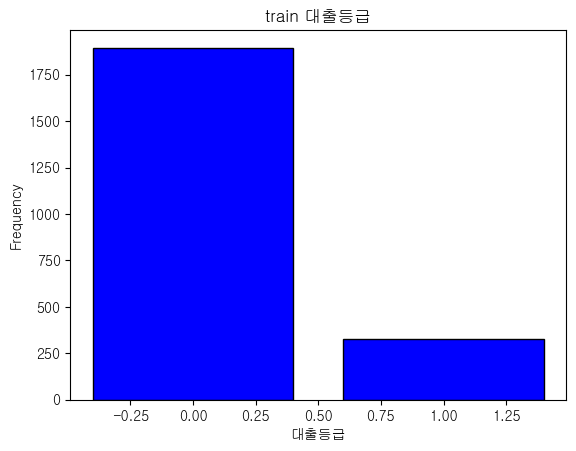

In [21]:
plt.hist(new_train_3["대출등급"], bins=range(3), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [22]:
X = new_train_3.drop(columns=['대출등급'])
y = new_train_3[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)
X.shape, y.shape

((3790, 45), (3790, 1))

0.0
1.0


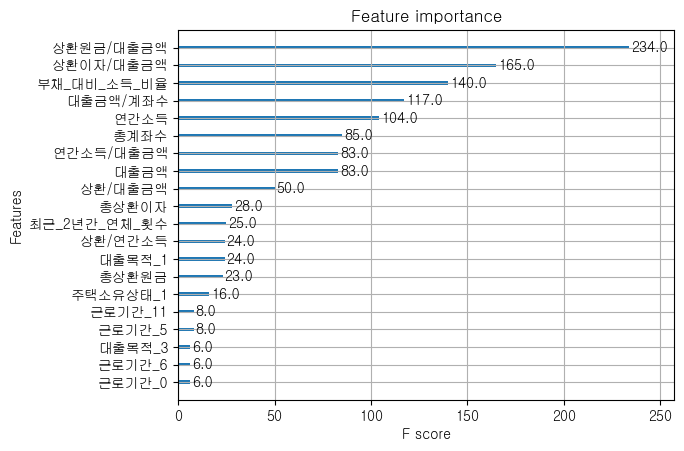

array([1, 0, 2, 'G', 3, 4], dtype=object)

In [23]:
xg = xgb.XGBClassifier()
model_3 = xg.fit(X, y)
pred = model_3.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))
xgb.plot_importance(model_3, importance_type='weight', max_num_features=20)
plt.show()

pred_3 = model_3.predict(test)
pred_3 = np.round(pred_3)
sub.loc[(sub['대출등급'] == 'G') & (pred_3 == 0) & (test["대출기간"] == 36), "대출등급"] = 4
sub["대출등급"].unique()

# FG

In [24]:
new_train_4 = train_36.copy()
new_train_4 = new_train_4[new_train_4["대출등급"] != 0]
new_train_4 = new_train_4[new_train_4["대출등급"] != 1]
new_train_4 = new_train_4[new_train_4["대출등급"] != 2]
new_train_4 = new_train_4[new_train_4["대출등급"] != 3]
new_train_4 = new_train_4[new_train_4["대출등급"] != 4]
new_train_4["대출등급"].unique()

array([5, 6], dtype=int64)

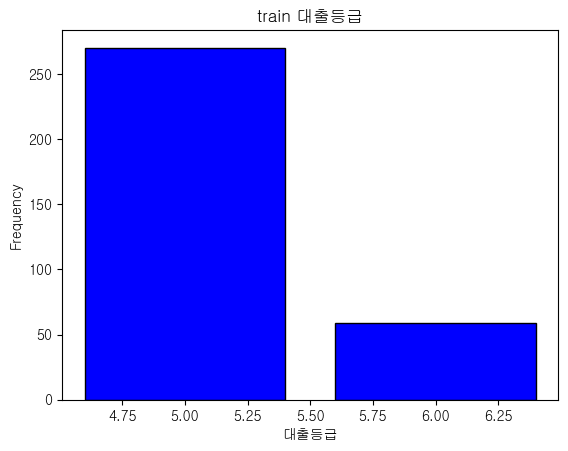

In [25]:
plt.hist(new_train_4["대출등급"], bins=range(5,8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [26]:
new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:0 if x==5 else x)
new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:1 if x==6 else x)
new_train_3["대출등급"].unique()

array([0, 1], dtype=int64)

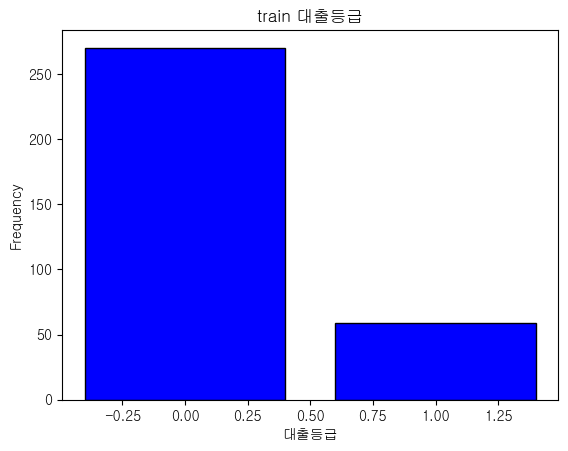

In [27]:
plt.hist(new_train_4["대출등급"], bins=range(3), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [28]:
X = new_train_4.drop(columns=['대출등급'])
y = new_train_4[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)
X.shape, y.shape

((540, 45), (540, 1))

0.0
1.0


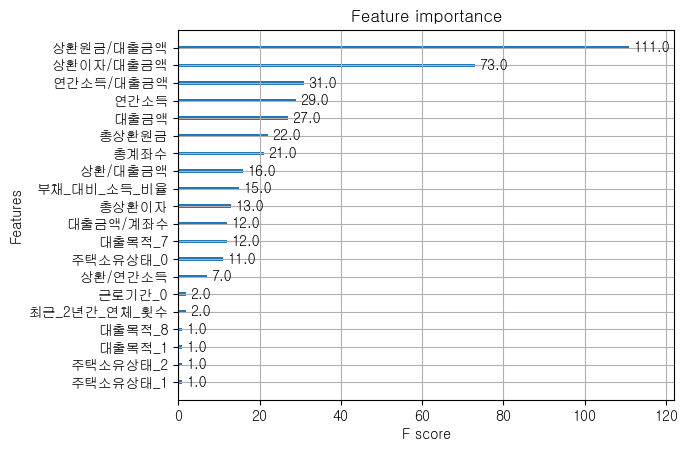

array([1, 0, 2, 'G', 5, 3, 4, 6], dtype=object)

In [29]:
xg = xgb.XGBClassifier()
model_4 = xg.fit(X, y)
pred = model_4.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))
xgb.plot_importance(model_4, importance_type='weight', max_num_features=20)
plt.show()

pred_4 = model_4.predict(test)
pred_4 = np.round(pred_4)
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 0) & (test["대출기간"] == 36), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 1) & (test["대출기간"] == 36), "대출등급"] = 6
sub["대출등급"].unique()

In [30]:
cnt = 0
for i in range(len(sub)):
    if sub.iloc[i,-1] == "G":
        cnt += 1
cnt

20968

# 72 months

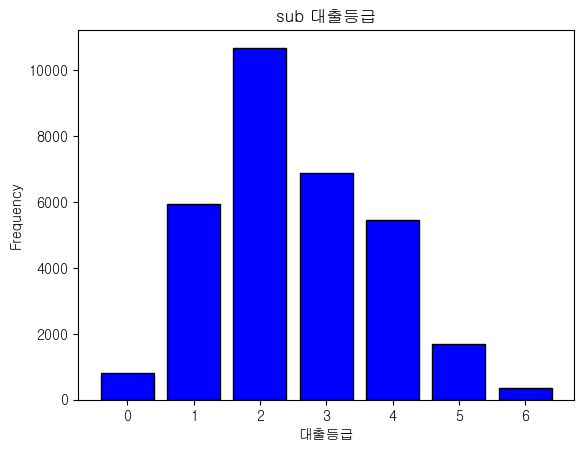

In [31]:
plt.hist(train_72["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("sub 대출등급")
plt.show()

# BCDE(AFG)

In [32]:
new_train_1 = train_72.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 6 else x)

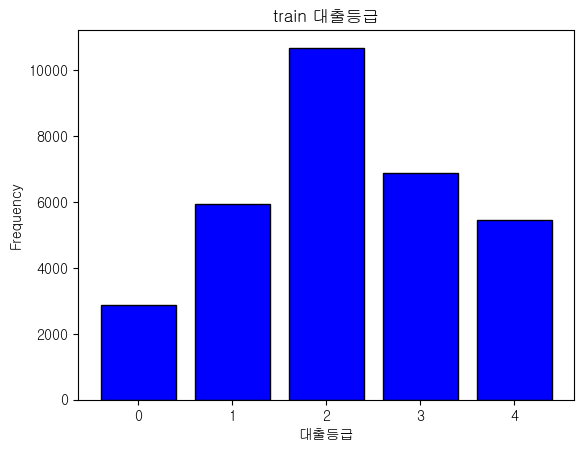

In [33]:
plt.hist(new_train_1["대출등급"], bins=range(6), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

0.09246310816324826
0.9939448702070409


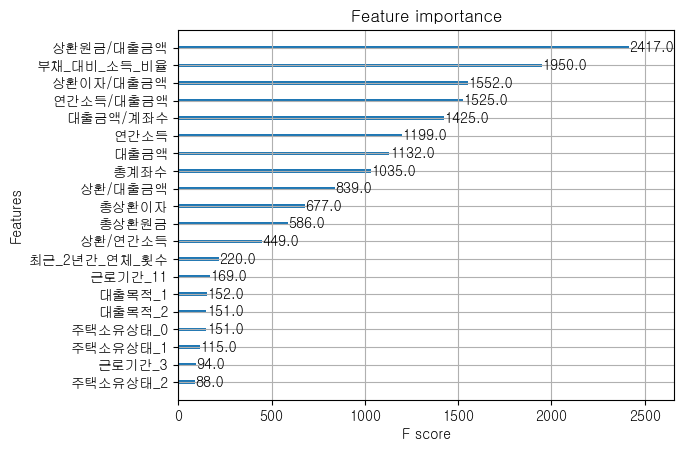

In [34]:
X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
xg = xgb.XGBClassifier()
model_1 = xg.fit(X, y)
pred = model_1.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))
xgb.plot_importance(model_1, importance_type='weight', max_num_features=20)
plt.show()

In [35]:
pred_1 = model_1.predict(test)
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 72), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 72), "대출등급"] = 2
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 3) & (test["대출기간"] == 72), "대출등급"] = 3
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 4) & (test["대출기간"] == 72), "대출등급"] = 4
sub["대출등급"].unique()

array([1, 0, 2, 5, 3, 'G', 4, 6], dtype=object)

# AFG

In [36]:
new_train_2 = train_72.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]
new_train_2 = new_train_2[new_train_2["대출등급"] != 3]
new_train_2 = new_train_2[new_train_2["대출등급"] != 4]
new_train_2["대출등급"].unique()

array([5, 6, 0], dtype=int64)

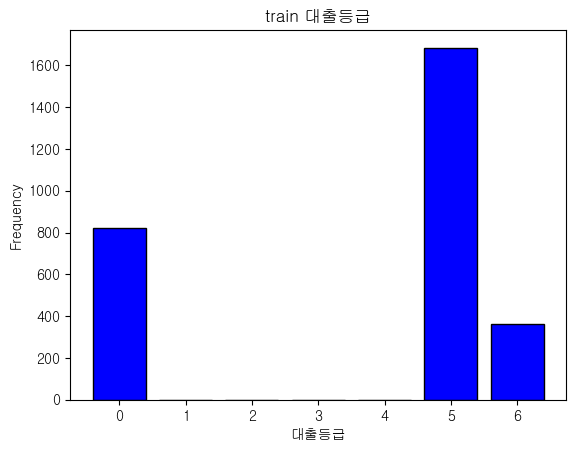

In [37]:
plt.hist(new_train_2["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [38]:
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==0 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:2 if x==6 else x)
new_train_2["대출등급"].unique()

array([1, 2, 0], dtype=int64)

In [39]:
X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]

0.0
1.0


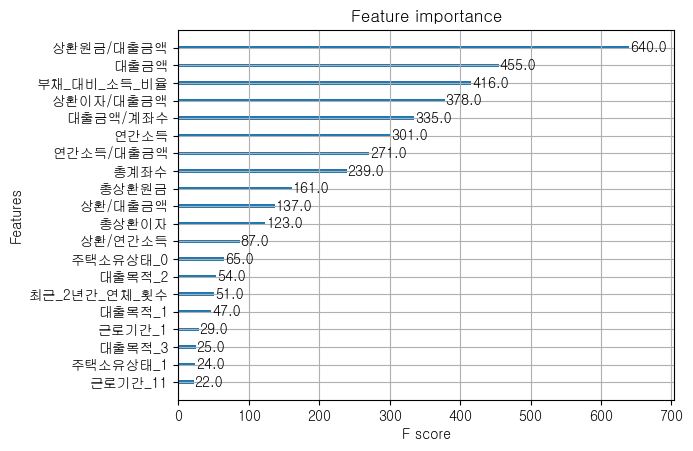

In [40]:
xg = xgb.XGBClassifier()
model_2 = xg.fit(X, y)
pred = model_2.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))
xgb.plot_importance(model_2, importance_type='weight', max_num_features=20)
plt.show()

In [41]:
pred_2 = model_2.predict(test)
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 72), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 1) & (test["대출기간"] == 72), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 2) & (test["대출기간"] == 72), "대출등급"] = 6
sub["대출등급"].unique()

array([1, 0, 2, 5, 3, 4, 6], dtype=object)

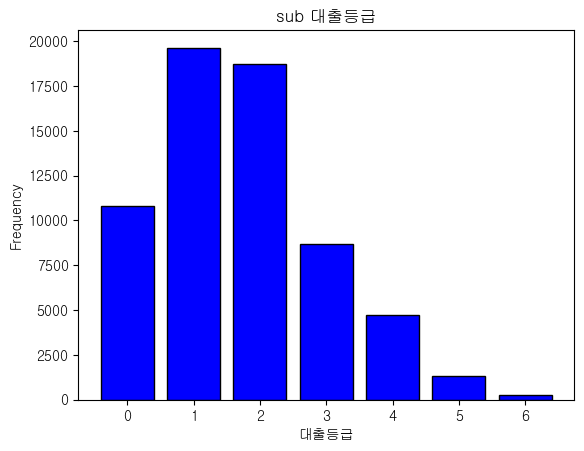

In [42]:
plt.hist(sub["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("sub 대출등급")
plt.show()

In [43]:
mapping_rank = {0 : "A",1 : "B",2 : "C",3 : "D",4 : "E",5 : "F",6 : "G"}
sub["대출등급"] = sub["대출등급"].replace(mapping_rank)
sub

,ID,대출등급
0,TEST_00000,B
1,TEST_00001,B
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C
...,...,...
64192,TEST_64192,D
64193,TEST_64193,D
64194,TEST_64194,D
64195,TEST_64195,C


In [44]:
sub.to_csv("submission/69.ABC(DEFG)_BCDE(AFG)_regression.csv",index=False)